# FIT5202 Data processing for big data

## Activity: Machine Learning with Spark (Clustering using K-Means)

This week we are going to look into clustering using K-Means alogrithm. We will look into the case study where <strong>we use machine learning to identify the involvement of the attackers</strong>.

## Table of Contents

* [K-Means Clustering](#one)
* [K-Means Clustering-DEMO](#demo)
* [Use Case : Problem Statement](#problem-statement)
    * [Data Loading](#loading)
    * [Data Preparation](#preparation)
    * [Feature Engineering](#fe)
    * [Clustering](#clustering)
    * [Silhouette Score ](#ss)    
* [Optimal Number of Clusters](#optimal)
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)
    * [Lab Task 4](#lab-task-4)


## K-Means Clustering <a class="anchor" name="one"></a>

Cluster analysis is an area of machine learning that focuses on finding patterns in unlabelled data. The main idea behind clustering is to group similar kinds of data together into clusters, in hopes of creating useful labels for these groups. This field is also known as `unsupervised learning`.

When supervised algorithms are used more for making predictions, unsupervised algorithms would be more useful for exploring data.
`K-means` is one of the simplest unsupervised algorithms used today, and it can help partition a set of **n** observations into **k** clusters or groups.




### K-Means Clustering DEMO <a class="anchor" name="demo"></a>
The following example shows the implementation of K-Means clustering for a simple dataset with three colummns i.e. <code>email,income and gender.</code> The pipeline used here is very familier to what we have been doing since the last 2 labs.

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong> 
Try to understand the steps shown in the example below. Briefly explain the pipeline implementation to your tutor to demonstrate your understanding about:
    <ul>
<li>1. The use of 3 different transformers for feature engineering</li>
<li>2. How pipeline API is is used to organize the steps.</li>
    </ul>
Also discuss about the <strong>Predictions</strong> and the <strong>Silhouette score</strong> that you see.
</div>

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#Create Spark Session
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

#Step 1 : Prepare the Data
df = spark.createDataFrame(
 [("a@email.com", 12000,"M"),
    ("b@email.com", 43000,"M"),
    ("c@email.com", 5000,"F"),
    ("d@email.com", 60000,"M"),
    ("e@email.com", 55000,"M"),
    ("f@email.com", 11000,"F")
 ],
 ["email",'income','gender'])

#Step 2 : Feature Engineering 
indexer = StringIndexer(inputCols=['email','gender'],outputCols=['email_index','output_index'])
encoder = OneHotEncoder(inputCols=['email_index','output_index'],outputCols=['email_vec','output_vec'])
assembler = VectorAssembler(inputCols=['email_vec','output_vec','income'],outputCol='features')
#Create a KMeans Model Estimator initialized with 2 clusters
k_means = KMeans(featuresCol='features', k=2)

#Step 3 : Pipeline API and ML Model
pipeline = Pipeline(stages = [indexer,encoder,assembler,k_means])
pipelineModel = pipeline.fit(df)

# Make predictions
predictions = pipelineModel.transform(df)
predictions.show()
# # Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
#HINT:You can use model.stages[-1] to access the model from the pipeline.
centers = pipelineModel.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+-----------+------+------+-----------+------------+-------------+-------------+--------------------+----------+
|      email|income|gender|email_index|output_index|    email_vec|   output_vec|            features|prediction|
+-----------+------+------+-----------+------------+-------------+-------------+--------------------+----------+
|a@email.com| 12000|     M|        0.0|         0.0|(5,[0],[1.0])|(1,[0],[1.0])|(7,[0,5,6],[1.0,1...|         1|
|b@email.com| 43000|     M|        1.0|         0.0|(5,[1],[1.0])|(1,[0],[1.0])|(7,[1,5,6],[1.0,1...|         0|
|c@email.com|  5000|     F|        2.0|         1.0|(5,[2],[1.0])|    (1,[],[])|(7,[2,6],[1.0,500...|         1|
|d@email.com| 60000|     M|        3.0|         0.0|(5,[3],[1.0])|(1,[0],[1.0])|(7,[3,5,6],[1.0,1...|         0|
|e@email.com| 55000|     M|        4.0|         0.0|(5,[4],[1.0])|(1,[0],[1.0])|(7,[4,5,6],[1.0,1...|         0|
|f@email.com| 11000|     F|        5.0|         1.0|    (5,[],[])|    (1,[],[])|   (7,[6],[11000


## Problem Statement <a class="anchor" name="problem-statement"></a>

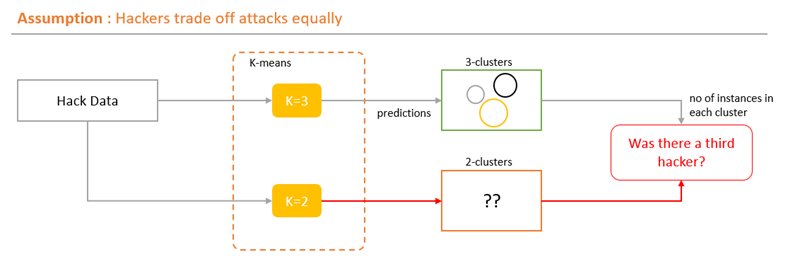

RhinoTech is a large technology firm that has been recently hacked. Luckily, the forensic engineers at the company have been able to grab metadata about each session used by the hackers to connect to RhinoTech servers. This data includes information such as session time, locations, words-per-minute typing speed, etc.
You have been informed that there are <strong style="color:red">three potential hackers that perpetrated the attack.     The RhinoTech forensic team are certain that the first two hackers were involved, but they want to know whether the third hacker was involved as well.</strong>

One last key piece of information you’ve been given by the forensic engineers is that: <blockquote><strong>The Hackers trade off attacks equally!</strong></blockquote> <p style="color:red">For example, imagine there were 100 attack instances. If 2 hackers were involved, then each hacker would have about 50 attacks. but in the case of 3 hackers, each would have only 33 attacks.</p>

To help you solve this problem, RhinoTech has provided you with a CSV file (Download from Moodle) that contains statistics about the attacks.


### Step 1 : Loading dataset  <a class="anchor" name="loading"></a>
First, let’s import the necessary Spark libraries we will use for data analysis, preparation, and clustering. Use <code>inferSchema=True</code> and display the schema of the dataset.


In [3]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
 
# Load csv file using spark session
data = spark.read.csv('data/hack_data.csv', header=True, inferSchema=True)

In [4]:
# print the schema
data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



>### Information on Dataset:
>Our dataset contains 334 attack instances, with the following information for each one:
>    - **Session_Connection_Time** - How long the session lasted in minutes?
>    - **Bytes Transferred** - Megabytes transferred during session
>    - **Kali_Trace_Used** - Whether the hacker was using Kali Linux
>    - **Servers_Corrupted** - Number of server corrupted during the attack
>    - **Pages_Corrupted** - Number of pages illegally accessed
>    - **Location** - Location attack came from
>    - **WPM_Typing_Speed** - Estimated typing speed based on session logs

### Step 2 : Data preparation <a class="anchor" name="preparation"></a>
`MLlib` library in Spark only accepts dataframes that have one column for clustering. This column should contain all the features in the form of vectors, with each vector corresponding to the features in that particular row.

<strong style="color:red">IMPORTANT: </strong>The `Location` column will be useless to consider because the hackers probably used VPNs to hide their real locations during the attacks. Therefore, we do not have to include that.

In [5]:
cols = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']

### Step 3 : Feature Engineering  <a class="anchor" name="fe"></a>
#### Assemble using VectorAssembler
We can assemble our attributes into one column using Spark’s **VectorAssembler**. When creating a **VectorAssembler** object, we must specify the input columns and the output column.

The input columns are a list of columns that we want to assemble, and the output column is just a name for the column created by the assembler.


In [6]:
assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled_data = assembler.transform(data)
assembled_data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed',
 'features']

#### Feature scaling : Standard Scaler
Next, we need to standardise our data. To accomplish this, Spark has its own **StandardScaler** which takes in two arguments — the name of the input column and the name of the output (scaled) column. <a href="https://spark.apache.org/docs/3.0.0/ml-features.html#standardscaler" target="_BLANK">[REF]</a>

In [7]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')

In [8]:
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)
scaled_data.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed',
 'features',
 'scaledFeatures']

### Step 4: Clustering using K-Means <a class="anchor" name="clustering"></a>

In [9]:
k_means = KMeans(featuresCol='scaledFeatures', k=3)

In [10]:
model = k_means.fit(scaled_data)

In [11]:
predictions = model.transform(scaled_data)
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   83|
|         0|   84|
+----------+-----+



## Was the third hacker involved?

Finally, it’s time to find out how many hackers were involved with the attacks. Using `.transform()` on the clustering model will transform our dataset so that a new attribute called `predictions` will be created. This new column will contain integers that indicate the cluster to which each attack instance has been classified.
Let’s take a look at how many instances are grouped into each cluster in the case of three clusters.

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> 
    Based on the above count you see for each group of attach, what do you think? Does it look like there were 3 hackers involved? Discuss this with your tutor?
    </div>

### Silhouette Score <a class="anchor" name="ss"></a>
Silhouette Score represents the separation distance between the resulting clusters. Higher the silhouette score, the better.

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.3068084951287429


<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong> 
    Recreate the above steps using the <strong>Pipeline API</strong>. In this case use <strong style="color:red">K = 2</strong> in the K-Means Estimator. Also calculate the Silhouette Score for the pipeline model. 
   
 <strong>HINT:</strong> You can use <code>model.stages[-1]</code> to access the model from the pipeline.
    </div>

### Step 1 : Load/Prepare the data
In this case you can use the same dataset from above. 

### Step 2 : Vector Assembler

In [13]:
#Define the vector Assembler Here
cols = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used', 'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']
assembler = VectorAssembler(inputCols=cols, outputCol='features')


### Step 3 : Standard Scaler

In [14]:
#Define the Standard Scaler here
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(assembled_data)


### Step 4 : K-Means (k=2)

In [15]:
#Define the K-Means estimator with number of clusters =2
k_means = KMeans(featuresCol='scaledFeatures', k=2)

### Step 5 : Pipeline
Plug all the steps above into a pipeline and generate the prediction count like before and analyze the number of instances in each cluster.

In [16]:
#Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, k_means])


In [17]:
#Fit and transform the pipeline to generate predictions

# Fit the pipeline to training documents.
model = pipeline.fit(data)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(data)

In [19]:
#Display the number of instances grouped by cluster
prediction.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



### Step 6: Silhouette Score

In [21]:
#Calculate the Silhouette Score for the Pipeline Model
from pyspark.ml.evaluation import ClusteringEvaluator
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(prediction)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6683623593283755


<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong> 
    Discuss your observations about the following with your tutor:
    <ol>
        <li>What is the difference is Silhoutte Score with K=3 vs K=2? What do you think is the optimal number of clusters in this case?
        <li>Based on the number of instances in each cluster, does it look like there were 3 hackers involved in the attack?</li>
    </ol>
    </div>
   

### Finding optimal number of clusters based on the Silhouette Score <a class="anchor" name="optimal"></a>
We already know, better Silhouette Score signifes a better separation of clusters. To find the optimal number of clusters, we can simply calculate the score for different cluster size and decide the optimal number of clusters based on the maximum score.

In the code below, we have calculated the Silhouette score for 2-10 cluster size.

In [26]:
#Here we are taking the data transformed by the StandardScaler
silhouette_arr=[]
for k in range(2,10):
    k_means= KMeans(featuresCol='scaledFeatures', k=k)
    model = k_means.fit(scaled_data)
    predictions = model.transform(scaled_data)
    silhouette = evaluator.evaluate(predictions)
    silhouette_arr.append(silhouette)
    print('No of clusters:',k,'Silhouette Score:',silhouette)

No of clusters: 2 Silhouette Score: 0.6683623593283755
No of clusters: 3 Silhouette Score: 0.3068084951287429
No of clusters: 4 Silhouette Score: -0.04792891045570489
No of clusters: 5 Silhouette Score: -0.10566048012215438
No of clusters: 6 Silhouette Score: -0.15490282725460747
No of clusters: 7 Silhouette Score: -0.09219448472733767
No of clusters: 8 Silhouette Score: -0.18498244751661183
No of clusters: 9 Silhouette Score: -0.25703729687435256


Text(0, 0.5, 'cost')

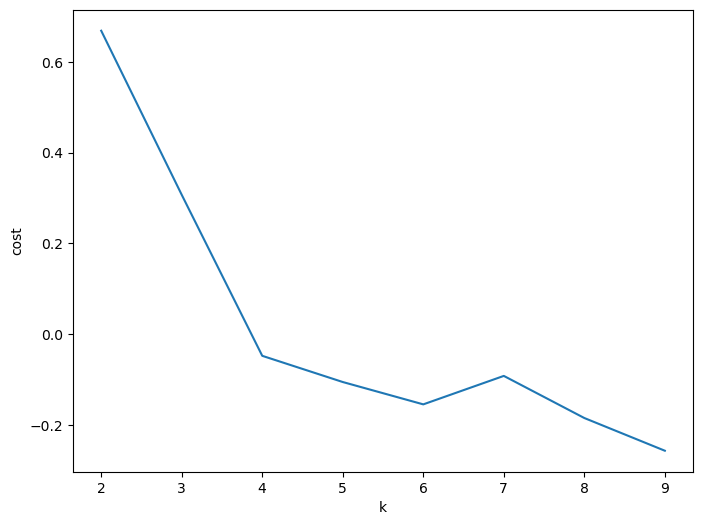

In [27]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_arr)
ax.set_xlabel('k')
ax.set_ylabel('cost')